In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import joblib
import warnings
warnings.filterwarnings("ignore")

In [57]:
# Load Data
df = pd.read_csv('/content/data.csv')
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

df.set_index("date", inplace=True)
df.head()

,orders,temperature,media_spend
date,,,
2020-05-02,54,18.270322,0.0
2020-05-03,63,19.882444,0.0
2020-05-04,56,16.878095,0.0
2020-05-05,65,21.878648,0.0
2020-05-06,64,21.112398,0.0


In [58]:
# Handle missing values in temperature
df['temperature'] = df['temperature'].fillna(df['temperature'].median())
print(df.head())

            orders  temperature  media_spend
date                                        
2020-05-02      54    18.270322          0.0
2020-05-03      63    19.882444          0.0
2020-05-04      56    16.878095          0.0
2020-05-05      65    21.878648          0.0
2020-05-06      64    21.112398          0.0


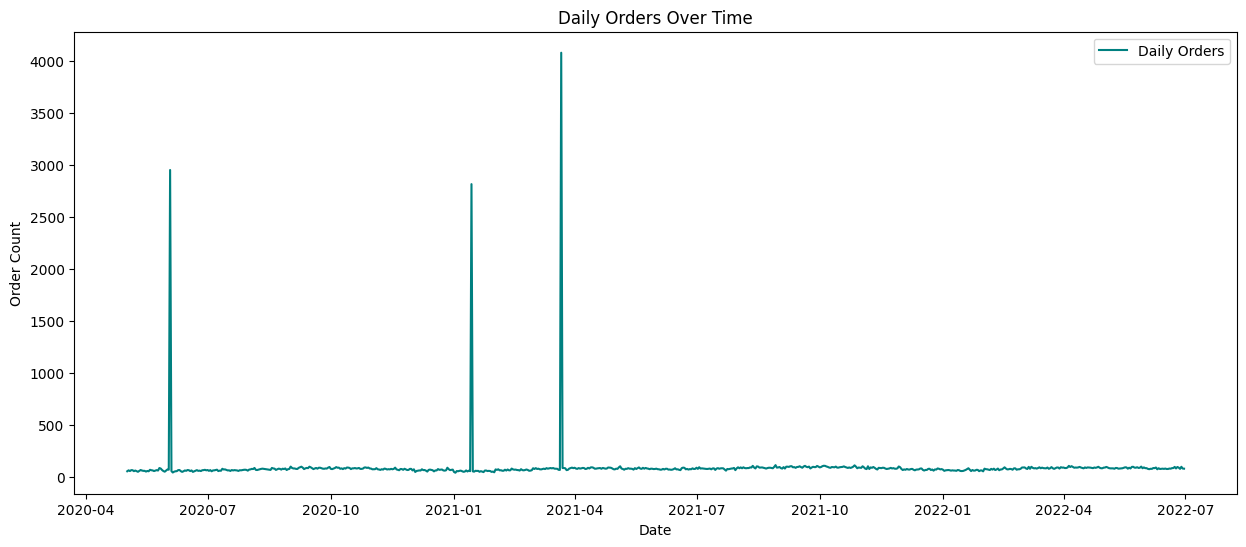

In [59]:
# Initial Visualization
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['orders'], color='teal', label='Daily Orders')
plt.title('Daily Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Order Count')
plt.legend()
plt.show()

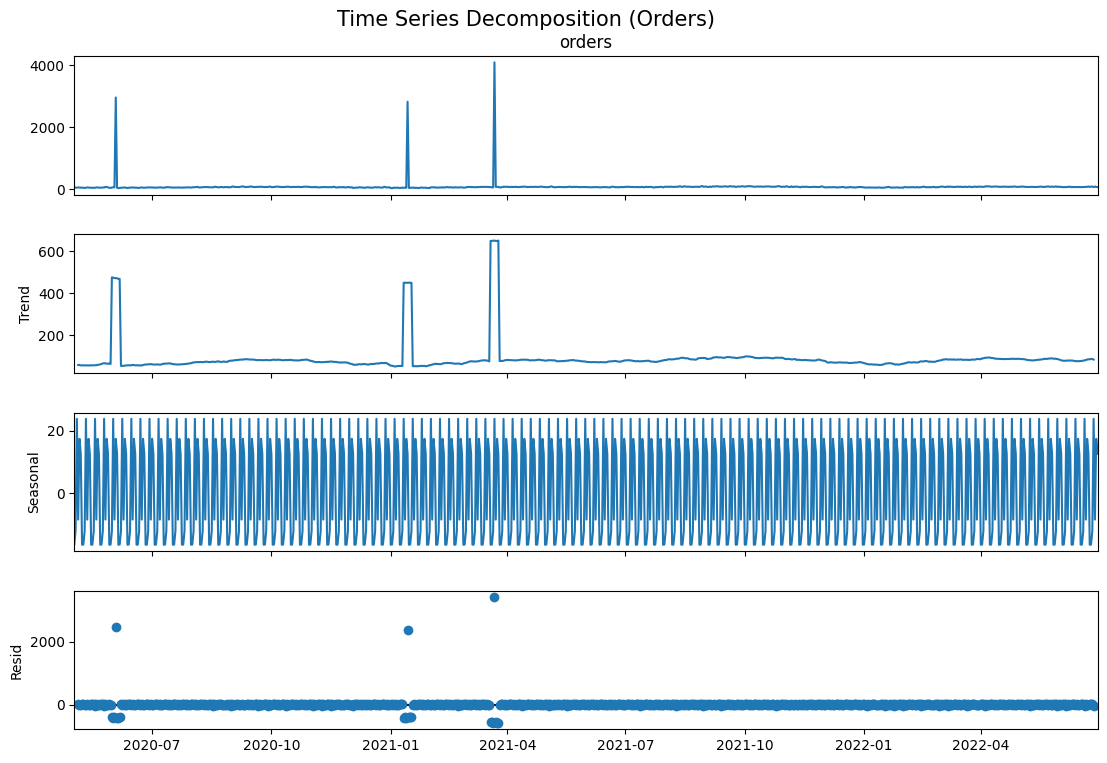

In [60]:
# Seasonal Decomposition
decomposition = seasonal_decompose(df['orders'], model='additive', period=7)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition (Orders)', fontsize=15)
plt.show()

In [61]:
# Stationarity Test (ADF Test)
adfdata = adfuller(df['orders'])
print(f'ADF Statistic: {adfdata[0]:.4f}')
print(f'P-value: {adfdata[1]:.4f}') # Goal: p < 0.05

ADF Statistic: -28.2604
P-value: 0.0000


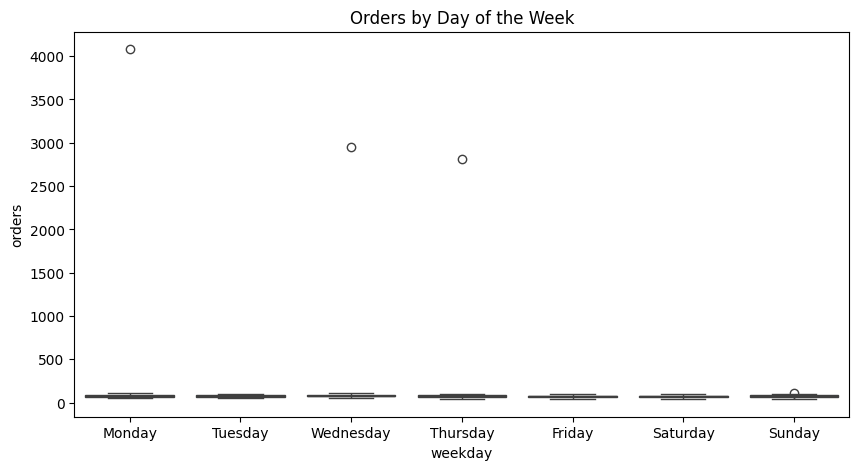

In [62]:
# Check for Seasonality
df['weekday'] = df.index.day_name()
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='orders', data=df,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Orders by Day of the Week')
plt.show()

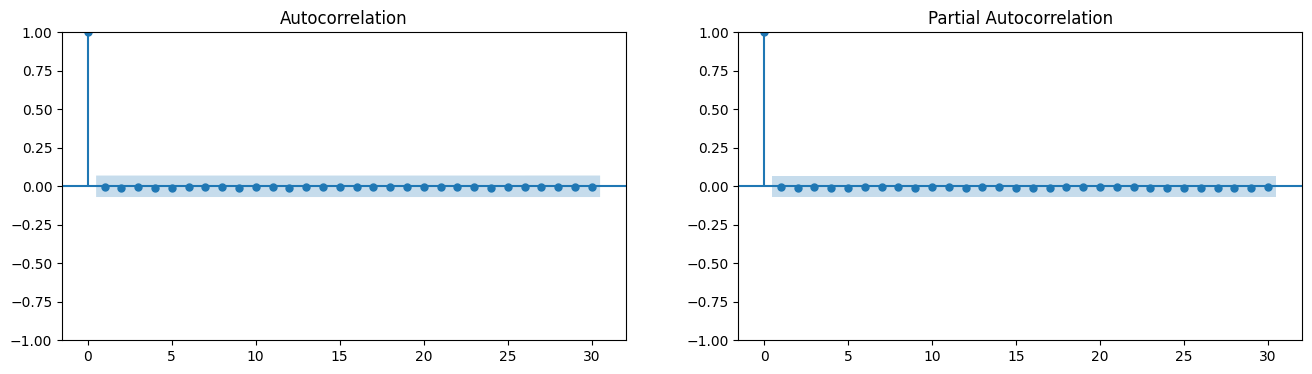

In [63]:
# ACF & PACF Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df['orders'], lags=30, ax=ax1)
plot_pacf(df['orders'], lags=30, ax=ax2)
plt.show()

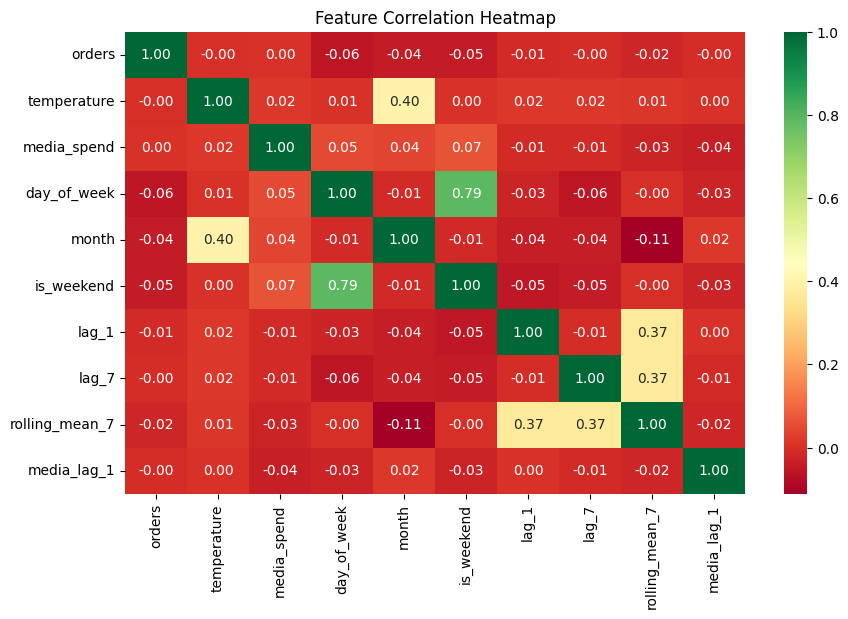

Feature Engineering Complete. Ready for modeling.


In [64]:
# FEATURE ENGINEERING

# A) Time-Based Features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# B) Lag Features
df['lag_1'] = df['orders'].shift(1)# Orders from yesterday
df['lag_7'] = df['orders'].shift(7)# Orders from last week same day

# C) Rolling Windows (Moving Averages)(last 7 days average)
df['rolling_mean_7'] = df['orders'].shift(1).rolling(window=7).mean()

# D) Interaction: Media Spend Effect
df['media_lag_1'] = df['media_spend'].shift(1)

# Drop rows with NaN values created by shifts
df.dropna(inplace=True)

# Visualizing Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='RdYlGn', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

print("Feature Engineering Complete. Ready for modeling.")

Model Training Complete.
Mean Absolute Error (MAE): 6.71 orders
RMSE: 11.62


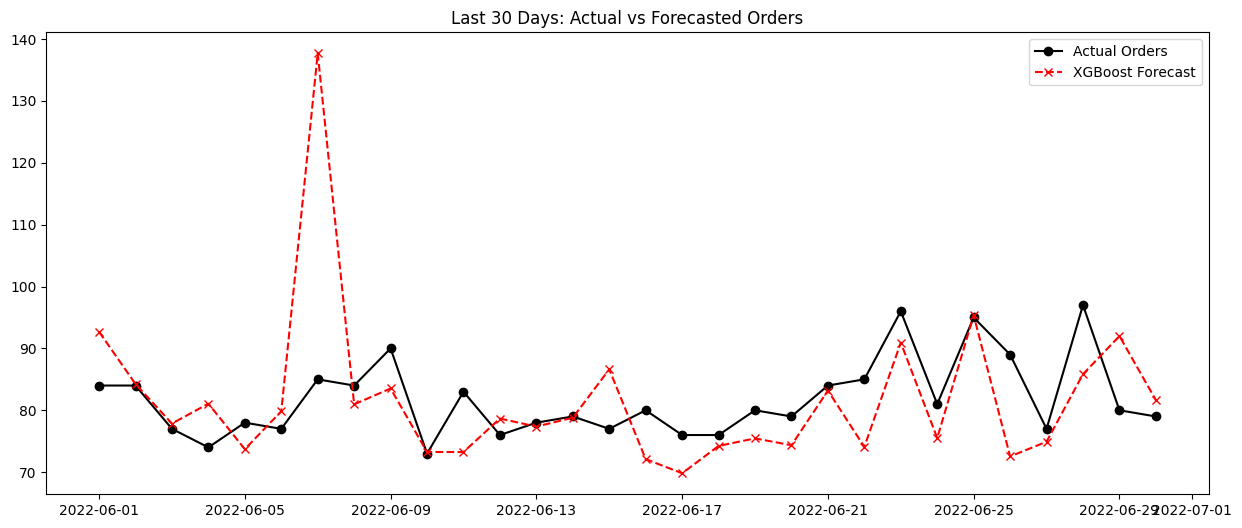

In [65]:
# 3. TIME SERIES MODELING (XGBoost)
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# A) Define Features and Target
# I exclude 'weekday' because it's a string; I use 'day_of_week' instead
features = ['temperature', 'media_spend', 'day_of_week', 'month',
            'is_weekend', 'lag_1', 'lag_7', 'rolling_mean_7', 'media_lag_1']
target = 'orders'

X = df[features]
y = df[target]

# B) Time-Based Split
# I take the last 30 days as the test set
test_days = 30
X_train = X[:-test_days]
y_train = y[:-test_days]
X_test = X[-test_days:]
y_test = y[-test_days:]

# C) Model Training
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5)
model.fit(X_train, y_train)

# D) Prediction & Evaluation
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Model Training Complete.")
print(f"Mean Absolute Error (MAE): {mae:.2f} orders")
print(f"RMSE: {rmse:.2f}")

# E) Visualizing Results (Actual vs Forecast)
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual Orders', color='black', marker='o')
plt.plot(y_test.index, predictions, label='XGBoost Forecast', color='red', linestyle='--', marker='x')
plt.title('Last 30 Days: Actual vs Forecasted Orders')
plt.legend()
plt.show()

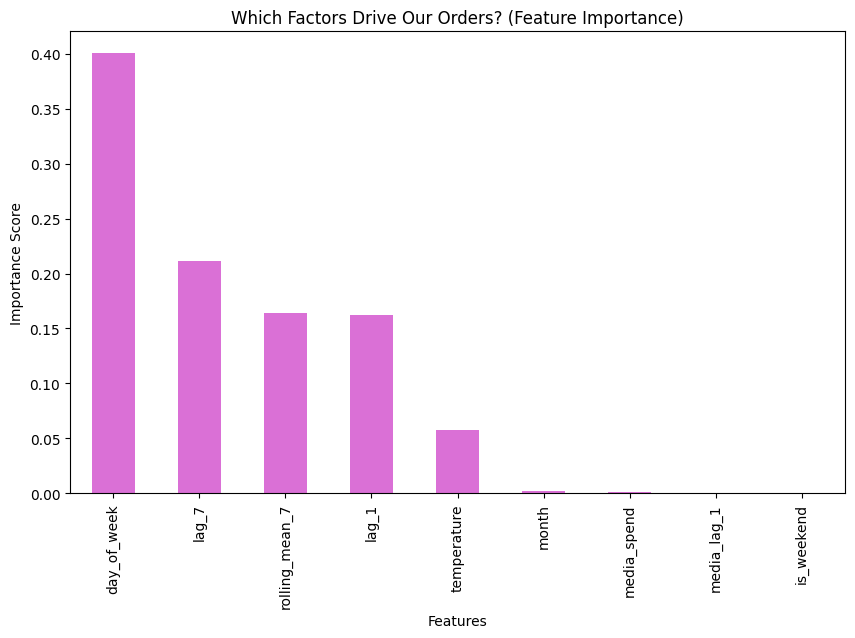

Top Factor identified: day_of_week


In [66]:
# 4. FEATURE IMPORTANCE

# Getting feature importance from XGBoost
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color='orchid')
plt.title('Which Factors Drive Our Orders? (Feature Importance)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

print("Top Factor identified:", importances.index[0])

In [67]:
# 6. STATISTICAL MODELING: SARIMA
import statsmodels.api as sm

train_series = y_train

# SARIMA(p,d,q)(P,D,Q)s
sarima_model = sm.tsa.statespace.SARIMAX(train_series,
                                        order=(1, 1, 1),
                                        seasonal_order=(1, 1, 1, 7),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

sarima_results = sarima_model.fit(disp=False)

# Forecast for the next 30 days
sarima_forecast = sarima_results.get_forecast(steps=30)
sarima_mean = sarima_forecast.predicted_mean

# Calculate MAE for SARIMA
sarima_mae = mean_absolute_error(y_test, sarima_mean)
print(f"SARIMA Mean Absolute Error: {sarima_mae:.2f} orders")

SARIMA Mean Absolute Error: 15.65 orders


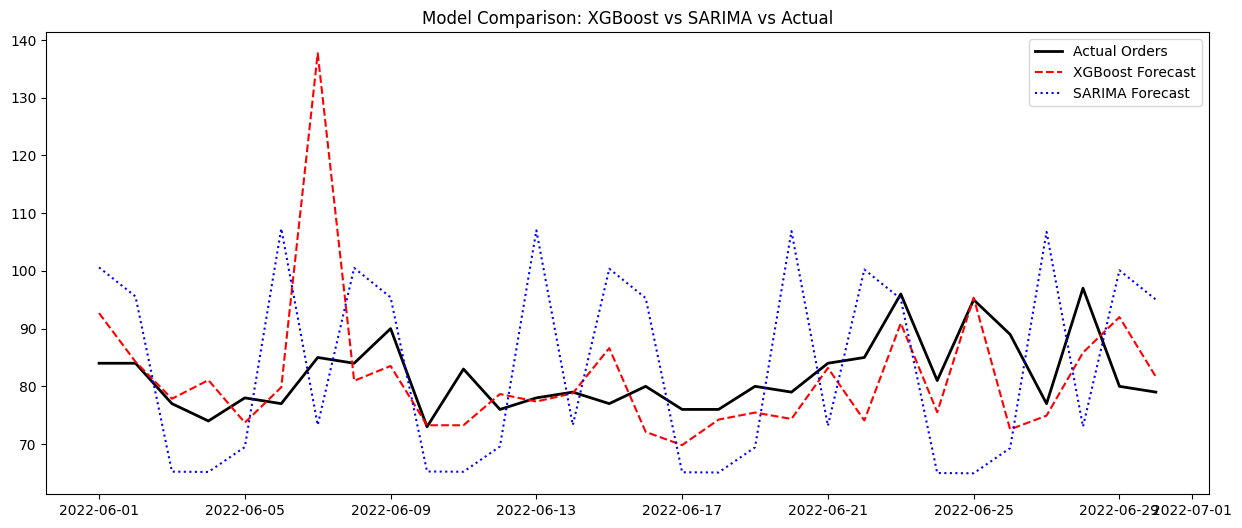

In [68]:
# 7. MODEL COMPARISON VISUALIZATION
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test.values, label='Actual Orders', color='black', lw=2)
plt.plot(y_test.index, predictions, label='XGBoost Forecast', color='red', linestyle='--')
plt.plot(y_test.index, sarima_mean, label='SARIMA Forecast', color='blue', linestyle=':')
plt.title('Model Comparison: XGBoost vs SARIMA vs Actual')
plt.legend()
plt.show()

In [69]:
# 8. SAVING MODELS & SCALERS (Joblib)
import joblib

# 1. Save the XGBoost Model
joblib.dump(model, 'sales_xgboost_model.joblib')

# 2. Save the SARIMA Results
sarima_results.save('sarima_model.pkl')

print("--- Time Series Models Saved Successfully! ---")
print("Files created: sales_xgboost_model.joblib, sarima_model.pkl")

--- Time Series Models Saved Successfully! ---
Files created: sales_xgboost_model.joblib, sarima_model.pkl
